In [1]:
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

tqdm.pandas()

In [2]:
from Data.DataModels.datasetFromSequences import SequenceDatasetCUDA
from Data.DataModels.dataModule import DataModule
from Models.modelLSTM import LSTMModel
from Models.modelMAMBA import MAMBAModel
from Models.modelTransformer import TransformerModel
from Models.moduleAdamW import AdamWModule
from Data.preprocessing import PreprocessCSVtoSequences

In [3]:
N_EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 0.0001
SEQUENCE_LENGTH = 120

VAL_PERC = .1
TEST_PERC = .1
CSV_PATH = 'Data/CSV/Binance_BTCUSDT_2024_minute.csv'
DATE_COLUMN = 'Date'
COLUMN_TO_SHIFT = 'Close'

In [4]:
btc_data = PreprocessCSVtoSequences(
    csv_path = CSV_PATH,
    date_column = DATE_COLUMN ,
    column_to_shift = COLUMN_TO_SHIFT,
    use_scaler = True,
    sequence_length = SEQUENCE_LENGTH,
    val_percentage = VAL_PERC,
    test_percentage = TEST_PERC
)

btc_data.preprocess()

Getting the change of price in a day...


  0%|          | 0/201460 [00:00<?, ?it/s]

Transforming date column to day_of_week, day_of_month, week_of_year and year columns...


  0%|          | 0/201460 [00:00<?, ?it/s]

Current shape after transformation of date column:  (201460, 10)
Current train and test shapes:  (161168, 10) (20146, 10)
Creating sequences from pandas DataFrame...


  0%|          | 0/161048 [00:00<?, ?it/s]

  0%|          | 0/20026 [00:00<?, ?it/s]

  0%|          | 0/20026 [00:00<?, ?it/s]

Train shape:  (120, 10)
Val shape:  (120, 10)
Test shape:  (120, 10)


In [5]:
data_module = DataModule(
    train_sequences = btc_data.train_sequences,
    val_sequences = btc_data.val_sequences,
    test_sequences = btc_data.test_sequences,
    dataset = SequenceDatasetCUDA,
    batch_size = BATCH_SIZE
)
data_module.setup()

In [6]:
btc_model = AdamWModule.load_from_checkpoint(
    'Checkpoints/btc-price/best_models/lstm-btc-checkpoint-v6.ckpt',
    n_features = btc_data.train_sequences[0][0].shape[1]
)

/home/agata/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.


In [7]:
predictions = []
labels = []

test_BTC_dataset = SequenceDatasetCUDA(btc_data.test_sequences)

for item in tqdm(test_BTC_dataset):
    sequence = item['sequence']
    label = item['label']

    _, output = btc_model(sequence.unsqueeze(dim = 0))
    predictions.append(output.item())
    labels.append(label.item())

  0%|          | 0/20026 [00:00<?, ?it/s]

In [8]:
len(predictions), len(btc_data.test_df)

(20026, 20146)

In [9]:
len(btc_data.test_df) - SEQUENCE_LENGTH

20026

In [10]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(btc_data.train_df[['close']])

In [11]:
scaler.min_

array([-3.18981379])

In [12]:
scaler.scale_

array([5.67913673e-05])

In [13]:
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_, scaler.scale_

In [14]:
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

In [15]:
predictions_descaled = descale(descaler, predictions)
labels_descaled = descale(descaler, labels)

In [16]:
labels_descaled[:5]

array([62839.19010886, 62839.9998267 , 62811.06986234, 62803.73989549,
       62805.68993535])

In [17]:
btc_data.test_df.head(5)

,day_of_week,day_of_month,week_of_year,month,year,open,high,low,close_change,close
181314,4,10,19,5,2024,63094.01,63094.01,62980.87,-88.22,62985.79
181315,4,10,19,5,2024,62985.78,62998.39,62970.64,-15.15,62970.64
181316,4,10,19,5,2024,62970.64,62989.60,62934.10,-36.53,62934.11
181317,4,10,19,5,2024,62934.10,62944.78,62920.00,-14.10,62920.01
181318,4,10,19,5,2024,62920.01,62920.01,62908.11,-5.31,62914.70


In [18]:
test_sequences_data = btc_data.test_df.iloc[SEQUENCE_LENGTH:]
len(test_sequences_data), len(predictions)

(20026, 20026)

In [19]:
test_sequences_data['date'] = test_sequences_data[['year', 'month', 'day_of_month']].astype(str).apply('-'.join, axis=1)
test_sequences_data['date'] = pd.to_datetime(test_sequences_data['date'])

/tmp/ipykernel_9128/1764992382.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sequences_data['date'] = test_sequences_data[['year', 'month', 'day_of_month']].astype(str).apply('-'.join, axis=1)
/tmp/ipykernel_9128/1764992382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sequences_data['date'] = pd.to_datetime(test_sequences_data['date'])


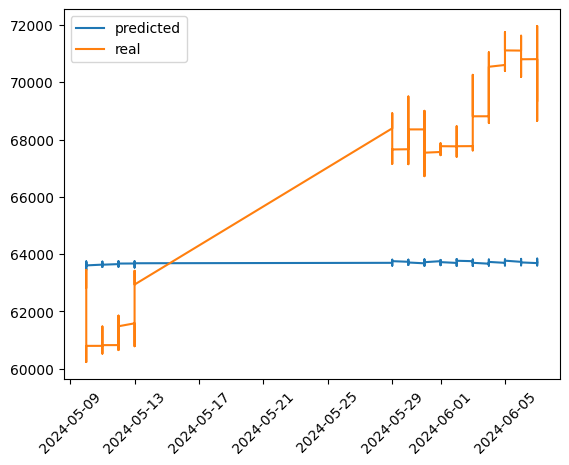

In [20]:
dates = matplotlib.dates.date2num(test_sequences_data.date.tolist())
plt.plot_date(dates, predictions_descaled, '-', label = 'predicted')
plt.plot_date(dates, labels_descaled, '-', label = 'real')
plt.xticks(rotation=45)
plt.legend()

In [21]:
df = pd.read_csv('Data/CSV/Binance_BTCUSDT_2024_minute.csv', parse_dates=['Date'])
df = df[int(len(df)*.9):]

In [22]:
df = df.iloc[SEQUENCE_LENGTH:]

In [23]:
len(df)

20026

In [24]:
len(predictions_descaled)

20026

In [25]:
df['Date']

181434   2024-01-18 21:59:00
181435   2024-01-18 21:58:00
181436   2024-01-18 21:57:00
181437   2024-01-18 21:56:00
181438   2024-01-18 21:55:00
                 ...        
201455   2024-01-01 00:05:00
201456   2024-01-01 00:04:00
201457   2024-01-01 00:03:00
201458   2024-01-01 00:02:00
201459   2024-01-01 00:01:00
Name: Date, Length: 20026, dtype: datetime64[ns]

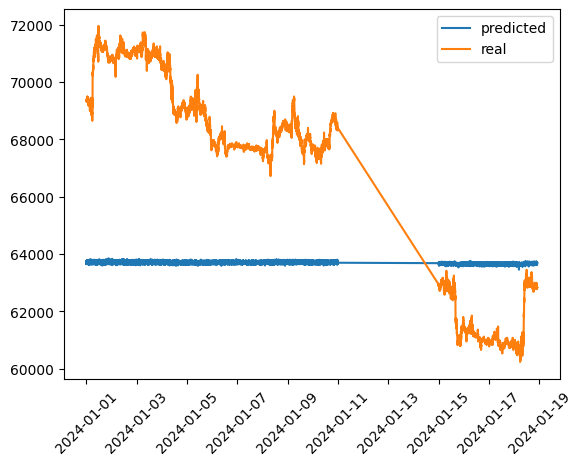

In [26]:
dates = matplotlib.dates.date2num(df['Date'].tolist())
plt.plot_date(dates, predictions_descaled, '-', label = 'predicted')
plt.plot_date(dates, labels_descaled, '-', label = 'real')
plt.xticks(rotation=45)
plt.legend()

In [27]:
transformer_model = AdamWModule.load_from_checkpoint(
    'Checkpoints/btc-price/best_models/transformer-btc-checkpoint-v6.ckpt',
    n_features = btc_data.train_sequences[0][0].shape[1]
)

transformer_predictions = []
transformer_labels = []

for item in tqdm(test_BTC_dataset):
    sequence = item['sequence']
    label = item['label']

    _, output = transformer_model(sequence.unsqueeze(dim = 0))
    transformer_predictions.append(output.item())
    transformer_labels.append(label.item())

transformer_predictions_descaled = descale(descaler, transformer_predictions)
transformer_labels_descaled = descale(descaler, transformer_labels)

/home/agata/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.
/home/agata/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


  0%|          | 0/20026 [00:00<?, ?it/s]

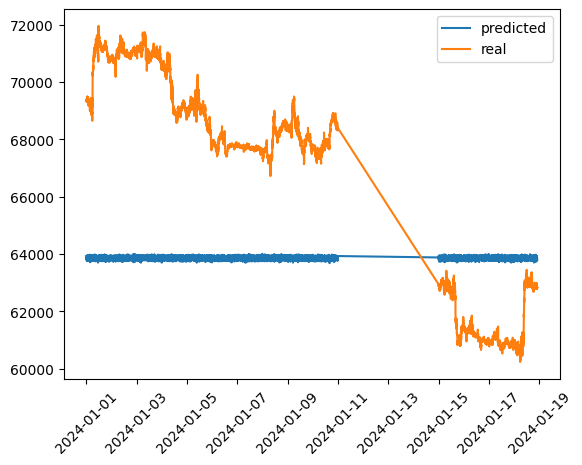

In [28]:
plt.plot_date(dates, transformer_predictions_descaled, '-', label = 'predicted')
plt.plot_date(dates, transformer_labels_descaled, '-', label = 'real')
plt.xticks(rotation=45)
plt.legend()

In [29]:
mamba_model = AdamWModule.load_from_checkpoint(
    'Checkpoints/btc-price/best_models/mamba-btc-checkpoint-v3.ckpt',
    n_features = btc_data.train_sequences[0][0].shape[1]
)

mamba_predictions = []
mamba_labels = []

for item in tqdm(test_BTC_dataset):
    sequence = item['sequence']
    label = item['label']

    _, output = mamba_model(sequence.unsqueeze(dim = 0))
    mamba_predictions.append(output.item())
    mamba_labels.append(label.item())

mamba_predictions_descaled = descale(descaler, mamba_predictions)
mamba_labels_descaled = descale(descaler, mamba_labels)

/home/agata/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.


  0%|          | 0/20026 [00:00<?, ?it/s]

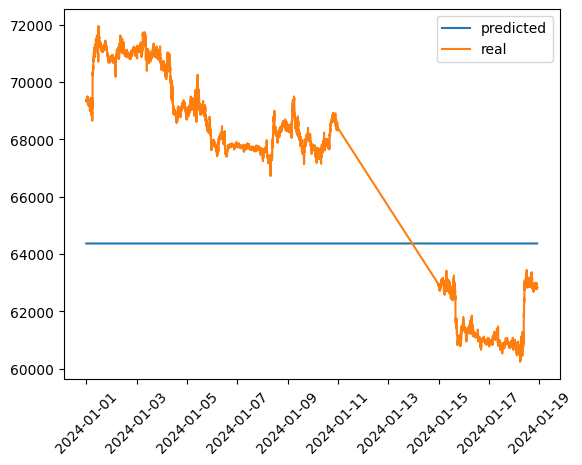

In [30]:
plt.plot_date(dates, mamba_predictions_descaled, '-', label = 'predicted')
plt.plot_date(dates, mamba_labels_descaled, '-', label = 'real')
plt.xticks(rotation=45)
plt.legend()